Загрузим уже частично посчитанную модель, но поменяем в ней sigma до 0.3, как в статье Гурвича, и посмотрим на прогноз дефицит бюджета

In [1]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from tqdm.contrib.telegram import tqdm, trange
from dotenv import load_dotenv
import os

from bob_telegram_tools.bot import TelegramBot
load_dotenv()
import pyreadr
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm

In [2]:
from olg import *

olg = OLG_model(G=60,T=250,N=N,epsilon=epsilon, rho=rho,
                gov_ratio=0.2,gov_const=gov_const,
                sigma = sigma,Pi=Pi,r = r,price_M =price_M,
                price_E=price_E, tau_I=tau_I,tau_II=tau_II,tau_Ins=tau_Ins,
                tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.99,
                theta =1,
                phi =0.23, # цель 38 миллионов в стеди стейт или 65% в начальном положении
                psi = 24.
                , omega=0.269
                , alpha = 0.35, delta=0.0608,
                A=A,initial=initial, Oil=Oil,eta =0.25,steady_max_iter=5000,max_iter=5000,
                steady_guess=steady_guess)


In [3]:
with open('olg_base_with_assets.file', 'rb') as f:
    olg_old=pickle.load(f)
olg_old.sigma[:] = 0.3
olg.k, olg.l, olg.c,\
olg.a, olg.steady, olg.L_share,\
olg.L, olg.L, olg.i, olg.I, olg.lmbda,\
olg.lmbda_to_price, olg.price, olg.price,\
olg.price_N, olg.sigma, olg.w = olg_old.k, olg_old.l, olg_old.c,\
olg_old.a, olg_old.steady, olg_old.L_share,\
olg_old.L, olg_old.L, olg_old.i, olg_old.I, olg_old.lmbda,\
olg_old.lmbda_to_price, olg_old.price, olg_old.price,\
olg_old.price_N, olg_old.sigma, olg_old.w

In [4]:
olg.steady_state()
olg.update_a_initial()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [5]:
olg.create_guess(250,300)

In [21]:
olg.T = 300
olg.steady_state()
olg.create_guess(250,300)

fig, ax = plt.subplots(3,3, figsize = (16,16))       
ax[0,0].plot(olg.k[0,:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$k_N$")
ax[0,0].plot(olg.k[1,:(olg.T+50)], alpha = (i+1)/niter, color="red", label = r"$k_N$")
ax[0,1].plot(olg.Consumption[:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$C$")
ax[0,2].plot(olg.Labor[:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$L$")
ax[1,0].plot(olg.w[:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$w$")
ax[1,1].plot(olg.price[:(olg.T+50)], alpha = (i+1)/niter, color="red", label = r"$p$")
ax[1,2].plot(olg.price[:(olg.T+50)], alpha = (i+1)/niter, color="blue", label = r"$p_N$")
ax[2,0].plot(olg.c[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="black", label = r"$c_{f}$")
ax[2,0].plot(olg.c[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="red", label = r"$c_{f}$")
ax[2,1].plot(olg.l[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="black", label = r"$l_{f}$")
ax[2,1].plot(olg.l[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="red", label = r"$l_{m}$")
ax[2,2].plot(olg.a[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="black", label = r"$a_{f}$")
ax[2,2].plot(olg.a[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="red", label = r"$a_{m}$")


ValueError: could not broadcast input array from shape (300,) into shape (50,)

eta0.3 path to steady 0:   0%|          | 0/249 [00:00<?, ?it/s]

NameError: name 'bot' is not defined

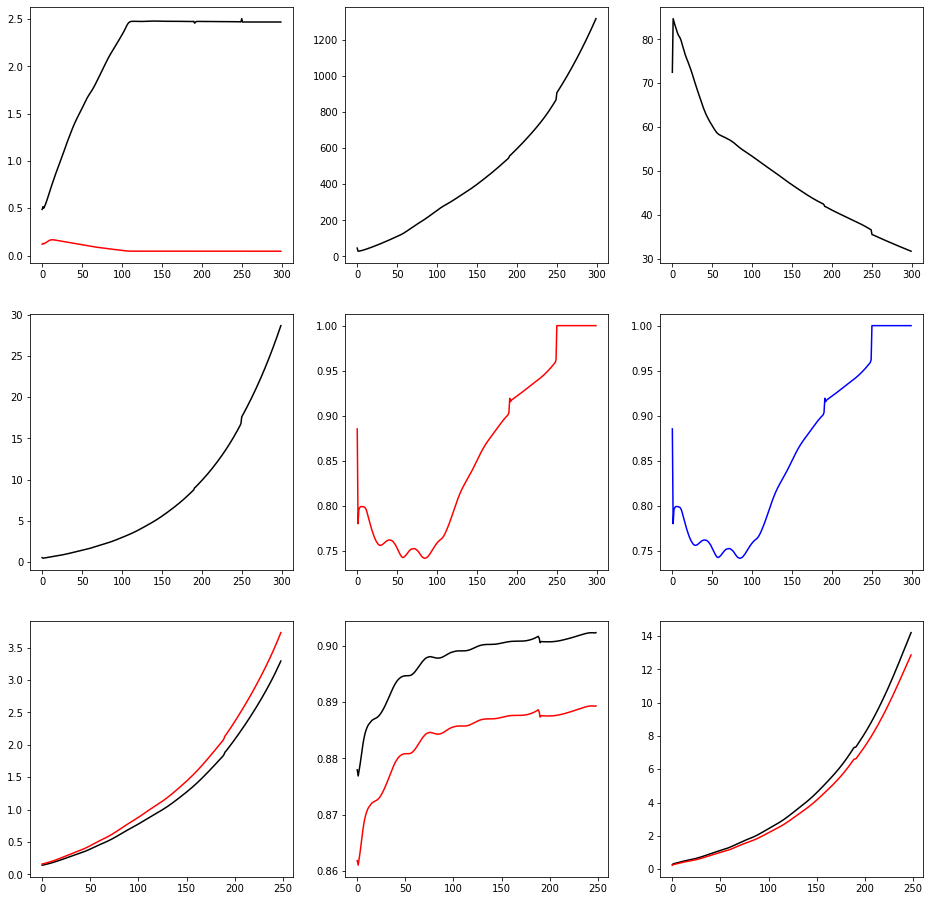

In [20]:
name = 'eta0.3'
niter = 1
for i in range(niter):
    for t in range(olg.T):
        olg.update_government(t)
    for t in range(1, olg.T):
        olg.update_household(t)
    for t in tqdm(reversed(range(1,olg.T)),
                      desc = f'{name} path to steady {i}',
                      total=olg.T-1,
                          token=os.getenv('comp_bot_token'),
                          chat_id=os.getenv('chat_id')):

        olg.update_guess(t)
        
    fig, ax = plt.subplots(3,3, figsize = (16,16))       
    ax[0,0].plot(olg.k[0,:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$k_N$")
    ax[0,0].plot(olg.k[1,:(olg.T+50)], alpha = (i+1)/niter, color="red", label = r"$k_N$")
    ax[0,1].plot(olg.Consumption[:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$C$")
    ax[0,2].plot(olg.Labor[:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$L$")
    ax[1,0].plot(olg.w[:(olg.T+50)], alpha = (i+1)/niter, color="black", label = r"$w$")
    ax[1,1].plot(olg.price[:(olg.T+50)], alpha = (i+1)/niter, color="red", label = r"$p$")
    ax[1,2].plot(olg.price[:(olg.T+50)], alpha = (i+1)/niter, color="blue", label = r"$p_N$")
    ax[2,0].plot(olg.c[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="black", label = r"$c_{f}$")
    ax[2,0].plot(olg.c[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="red", label = r"$c_{f}$")
    ax[2,1].plot(olg.l[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="black", label = r"$l_{f}$")
    ax[2,1].plot(olg.l[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="red", label = r"$l_{m}$")
    ax[2,2].plot(olg.a[0,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="black", label = r"$a_{f}$")
    ax[2,2].plot(olg.a[1,:,1:(olg.T)].diagonal(-olg.G+1), alpha = (i+1)/niter, color="red", label = r"$a_{m}$")
    bot.update_plot(msg, fig)
    with open(f'olg_{name}.file', 'wb') as f:
        pickle.dump(olg, f,protocol = pickle.HIGHEST_PROTOCOL)

    price_update = np.array([item[-1]['x'][-1] for key, item in olg.history.items() if len(item)!=0])
    error = abs(0.5*(olg.price[1:(olg.T)]-price_update)/(olg.price[1:(olg.T)]+price_update))
    print(error)
    if max(error) < tol/10:
        break
bot.clean_tmp_dir()